In [31]:
import pandas as pd
import emcee
import numpy as np
import matplotlib.pyplot as plt

In [34]:
def clean_cloudy_line_file(filename, name='emissivity'):
    '''
    My method for making cloudy line emissivity files more user friendly. 
    To pull emissivities for a given line from each grid step, 
    read in the df and use df.loc['HE_2_1640.00A'] format. 
    '''
    df = pd.read_csv(filename, sep='\t+', header=0, names=[name], comment='#', engine='python')
    df = df[df.index.str.contains('iteration') == False]
    df.index = df.index.str.replace('  ', '_')
    df.index = df.index.str.replace(' ', '_')
    df.index = df.index.str[:-1]
    
    return df

def clean_cloudy_line_file_line_normalized(filename, name='emissivity', normalization_line='H_1_4861.33A'):
    '''
    My method for making cloudy line emissivity files more user friendly. 
    To pull emissivities for a given line from each grid step, 
    read in the df and use df.loc['HE_2_1640.00A'] format. 
    '''
    df = pd.read_csv(filename, sep='\t+', header=0, names=[name], comment='#', engine='python')
    df = df[df.index.str.contains('iteration') == False]
    df.index = df.index.str.replace('  ', '_')
    df.index = df.index.str.replace(' ', '_')
    df.index = df.index.str[:-1]
    df[name] = df[name]/df.loc[normalization_line, name]
    
    return df

In [16]:
def log_prob(x, mu, cov):
    diff = x - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

In [17]:
ndim = 5

np.random.seed(42)
means = np.random.rand(ndim)

cov = 0.5 - np.random.rand(ndim**2).reshape((ndim, ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov, cov)

In [18]:
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

In [19]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])

In [20]:
log_prob(p0[0], means, cov)

-2.5960945890854434

In [21]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

In [22]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

AttributeError: you must run the sampler with 'store == True' before accessing the results

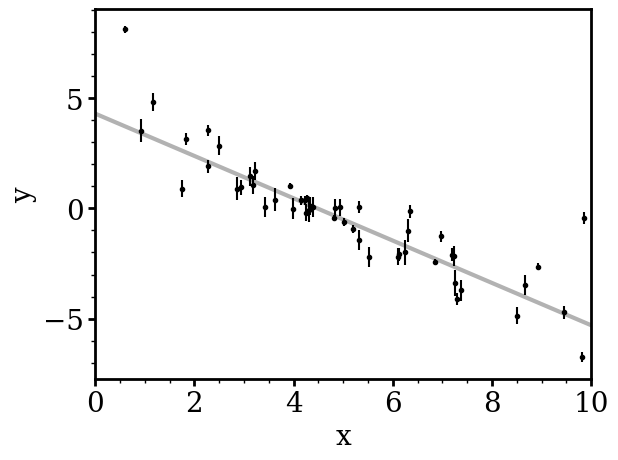

In [23]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


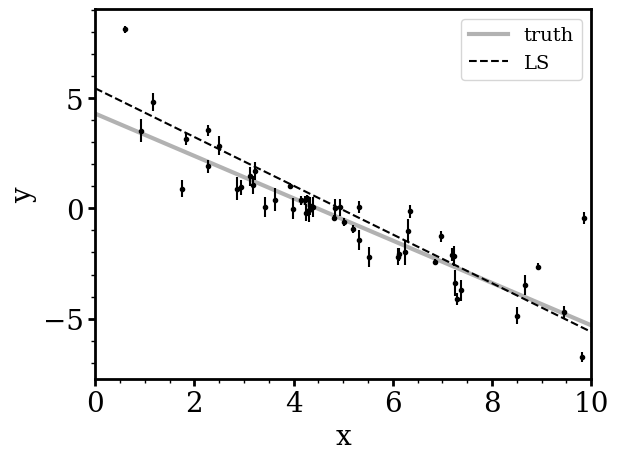

In [24]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [25]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


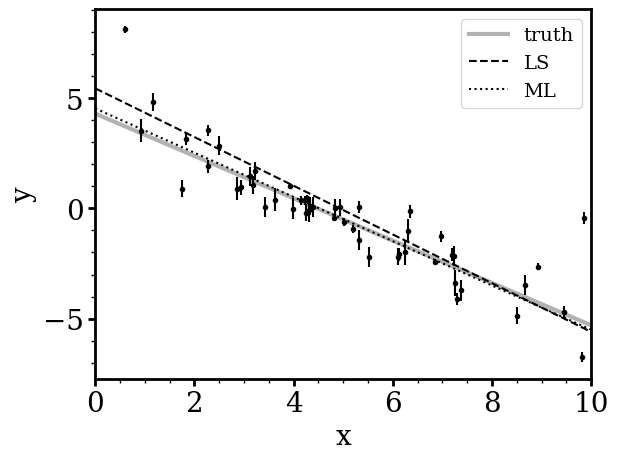

In [26]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [47]:
BPASS_135_300_single_hden3_path = "/Users/njc5787/Research/cloudy_model_library/cloudy_model_library_complete/BPASS/solar_abundances/hden3/BPASSv2.2.1_imf135_300_burst_binary_models/sedBPASSv2.2.1_imf135_300_burst_binary.ascii_age6.0_zstar0.2_hden3_z0.2_logU-2.0.ilin"
norm = clean_cloudy_line_file_line_normalized(BPASS_135_300_single_hden3_path, 'emissivity_hb_normalized')

norm.loc['H_1_4861.33A', 'emissivity_hb_normalized']
norm

,emissivity_hb_normalized
N_4_765.147A,0.006671
N_3_991.000A,0.003569
C_3_977.020A,0.075170
C_2_904.142A,0.005108
C_2_1036.34A,0.006786
...,...
O_3_1660.81A,0.050266
O_3_1666.15A,0.147304
O_5_1218.34A,0.000000
si_3_1892.03A,0.259575


<ErrorbarContainer object of 3 artists>

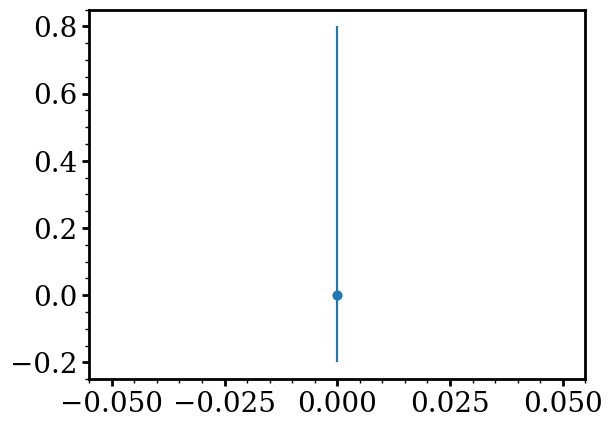